In [35]:
import torch
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm
import os
import CNNImageClassifier
from data_loader import get_dataloaders
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import CNNAttentionTransformerClassifier
import CNNAttentionImageClassifier

In [36]:
data_dir = '../data/final/'
split_dir = '../splits/'
batch_size = 32

# Load the test set
_, _, test_loader = get_dataloaders(data_dir, label_path=os.path.join(data_dir, 'labels.pt'), split_dir=split_dir, batch_size=batch_size)

c:\classifier\src\data_loader.py:14: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [37]:
# Function to load all models and dynamically set arguments based on the model_name
def load_all_models(model_dir, device):
    models = {}
    
    # # Regex pattern to extract layer_count, filter_size, kernel, pool, and lr from model_name
    pattern = re.compile(r'([A-Za-z]+)_L(\d+)_F(\d+)_K(\d+)_P(\d+)_lr([\de\.-]+)')
    
    for model_name in os.listdir(model_dir):
        model_path = os.path.join(model_dir, model_name, 'model.pth')
        if os.path.exists(model_path):
            # Parse the model_name to extract the hyperparameters
            match = pattern.match(model_name)
            if match:
                model_type = match.group(1)
                layer_count = int(match.group(2))
                filter_size = int(match.group(3))
                kernel = int(match.group(4))
                pool = int(match.group(5))
                lr = float(match.group(6))

                # Dynamically instantiate the model using the parsed values
                if model_type == 'CNN':
                    model = CNNImageClassifier.CNNImageClassifier(
                        input_size=(3, 256, 256), num_classes=4, num_filters=filter_size, 
                        kernel_size=kernel, pool_size=pool, num_layers=layer_count, fc_size=512
                    ).to(device)
                elif model_type == 'CNNAttention':
                    model = CNNAttentionImageClassifier.CNNAttentionImageClassifier(
                        input_size=(3, 256, 256),
                        num_classes=4,
                        num_filters=filter_size,
                        kernel_size=kernel,
                        pool_size=pool,
                        num_conv_layers=layer_count,
                        attention_reduction=16,
                        attention_kernel_size=3,
                        fc_size=128,
                        dropout=0.3
                    ).to(device)
                elif model_type == 'CNNTransformer':
                    model = CNNAttentionTransformerClassifier.CNNAttentionTransformerClassifier(
                        input_size=(3, 256, 256),
                        num_classes=4, 
                        num_filters=filter_size,
                        kernel_size=kernel, 
                        pool_size=pool, 
                        num_conv_layers=layer_count, 
                        transformer_dim=128, 
                        nhead=4, 
                        num_transformer_layers=3, 
                        dim_feedforward=256, 
                        dropout=0.3,
                        fc_size=128
                    ).to(device)
                
                # Load the state_dict (weights) from the checkpoint
                checkpoint = torch.load(model_path)
                model.load_state_dict(checkpoint['state_dict'])
                model.eval()

                # Store the model with its corresponding name
                models[model_name] = model
    
    return models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_dir = '../model/'

# Load all models
models = load_all_models(model_dir, device)

# Check loaded models
print(f"Loaded models: {list(models.keys())}")

C:\Users\waqaa\AppData\Local\Temp\ipykernel_21464\2853240847.py:62: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Loaded models: ['CNNAttention_L5_F64_K5_P2_lr0.0001', 'CNNTransformer_L5_F64_K5_P2_lr0.0001', 'CNN_L5_F64_K5_P2_lr0.0001']


In [38]:
def evaluate_all_models(models, test_loader, device):
    model_results = {}

    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")
        all_preds = []
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for imgs, labels in tqdm(test_loader):
                imgs = imgs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(imgs)
                probs = F.softmax(outputs, dim=1)  # Get probabilities using softmax
                preds = probs.argmax(dim=1)        # Predicted class labels

                # Convert one-hot labels to class indices
                if labels.ndim > 1:  # if labels are one-hot encoded
                    labels = labels.argmax(dim=1)

                # predictions, probabilities, and labels
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Store predictions, probabilities, and labels for each model
        model_results[model_name] = {
            'preds': np.array(all_preds),
            'probs': np.array(all_probs),
            'labels': np.array(all_labels)
        }
    
    return model_results

# Get predictions, probabilities, and true labels for all models
model_results = evaluate_all_models(models, test_loader, device)

Evaluating model: CNNAttention_L5_F64_K5_P2_lr0.0001


100%|██████████| 7/7 [00:16<00:00,  2.40s/it]


Evaluating model: CNNTransformer_L5_F64_K5_P2_lr0.0001


100%|██████████| 7/7 [00:15<00:00,  2.17s/it]


Evaluating model: CNN_L5_F64_K5_P2_lr0.0001


100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


In [40]:
# model_name cleaning function
def clean_model_name(model_name):
    # split by _ keep the first part
    return model_name.split('_')[0]

In [41]:
n_classes = 4

# color map with 3 distinct colors for the models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

def calculate_roc_auc(model_results, n_classes):
    roc_data = {}

    for model_name, results in model_results.items():
        labels = results['labels']
        probs = results['probs']

        # Micro-average
        fpr_micro, tpr_micro, _ = roc_curve(label_binarize(labels, classes=np.arange(n_classes)).ravel(), probs.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)

        roc_data[model_name] = {
            'fpr_micro': fpr_micro,
            'tpr_micro': tpr_micro,
            'roc_auc_micro': roc_auc_micro
        }

    return roc_data

def calculate_prc_auc(model_results, n_classes):
    prc_data = {}

    for model_name, results in model_results.items():
        labels = results['labels']
        probs = results['probs']

        # Micro-average
        precision_micro, recall_micro, _ = precision_recall_curve(label_binarize(labels, classes=np.arange(n_classes)).ravel(), probs.ravel())
        prc_auc_micro = auc(recall_micro, precision_micro)

        prc_data[model_name] = {
            'precision_micro': precision_micro,
            'recall_micro': recall_micro,
            'prc_auc_micro': prc_auc_micro
        }

    return prc_data

# Calculate ROC and PRC AUCs for all models
roc_data = calculate_roc_auc(model_results, n_classes)
prc_data = calculate_prc_auc(model_results, n_classes)

# Create subplots with 1 row and 2 columns for side-by-side plots
fig = make_subplots(rows=1, cols=2, subplot_titles=("ROC Curve", "Precision-Recall Curve"))

# Plot ROC curve for each model in the first column, applying consistent colors
for idx, (model_name, roc) in enumerate(roc_data.items()):
    fig.add_trace(
        go.Scatter(x=roc['fpr_micro'], y=roc['tpr_micro'], mode='lines', name=clean_model_name(model_name),
                   line=dict(color=colors[idx % len(colors)]), showlegend=True),
        row=1, col=1
    )

# Plot PRC curve for each model in the second column, applying the same colors
for idx, (model_name, prc) in enumerate(prc_data.items()):
    fig.add_trace(
        go.Scatter(x=prc['recall_micro'], y=prc['precision_micro'], mode='lines', name=model_name,
                   line=dict(color=colors[idx % len(colors)]), showlegend=False),
        row=1, col=2
    )

# Update layout for the overall figure
fig.update_layout(
    title_text="ROC Curve and Precision-Recall Curve Side by Side",
    xaxis_title="False Positive Rate (ROC)",
    yaxis_title="True Positive Rate (ROC)",
    xaxis2_title="Recall (PRC)",
    yaxis2_title="Precision (PRC)"
)

fig.show()

In [47]:
# Sorting models based on ROC AUC and extracting the top two
sorted_roc_models = sorted(roc_data.items(), key=lambda x: x[1]['roc_auc_micro'], reverse=True)
best_model_roc = sorted_roc_models[0][0]
second_best_model_roc = sorted_roc_models[1][0]

# Sorting models based on PRC AUC and extracting the top two
sorted_prc_models = sorted(prc_data.items(), key=lambda x: x[1]['prc_auc_micro'], reverse=True)
best_model_prc = sorted_prc_models[0][0]
second_best_model_prc = sorted_prc_models[1][0]

# Print the best and second best models
print(f"Best model based on ROC AUC: {best_model_roc}")
print(f"Second-best model based on ROC AUC: {second_best_model_roc}")
print(f"Best model based on PR AUC: {best_model_prc}")
print(f"Second-best model based on PR AUC: {second_best_model_prc}")

# Print the AUC values for ROC
print(f"\nROC AUC values:")
for model_name, roc in roc_data.items():
    print(f"{model_name}: {roc['roc_auc_micro']:.3f}")

# Print the AUC values for PRC
print(f"\nPRC AUC values:")
for model_name, prc in prc_data.items():
    print(f"{model_name}: {prc['prc_auc_micro']:.3f}")

Best model based on ROC AUC: CNNAttention_L5_F64_K5_P2_lr0.0001
Second-best model based on ROC AUC: CNN_L5_F64_K5_P2_lr0.0001
Best model based on PR AUC: CNNAttention_L5_F64_K5_P2_lr0.0001
Second-best model based on PR AUC: CNN_L5_F64_K5_P2_lr0.0001

ROC AUC values:
CNNAttention_L5_F64_K5_P2_lr0.0001: 0.913
CNNTransformer_L5_F64_K5_P2_lr0.0001: 0.816
CNN_L5_F64_K5_P2_lr0.0001: 0.902

PRC AUC values:
CNNAttention_L5_F64_K5_P2_lr0.0001: 0.818
CNNTransformer_L5_F64_K5_P2_lr0.0001: 0.608
CNN_L5_F64_K5_P2_lr0.0001: 0.796


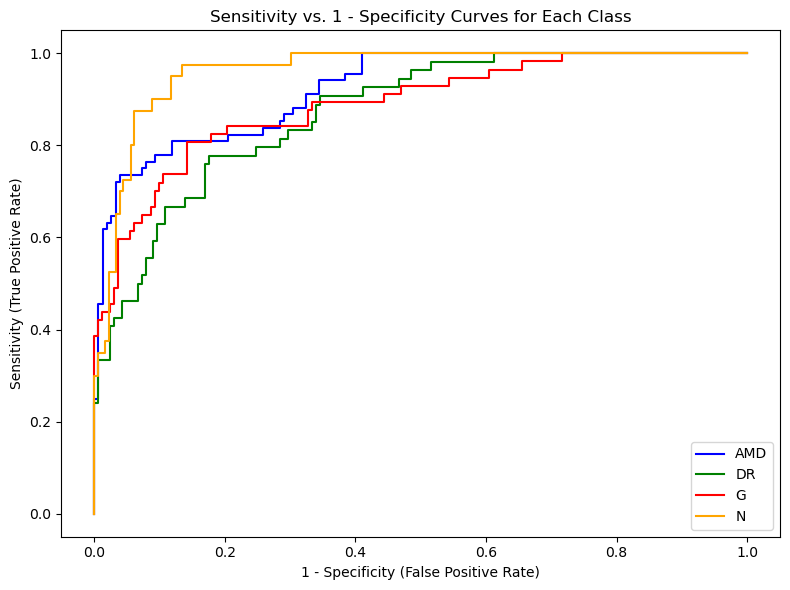

In [65]:
# Define the classes and their corresponding colors
classes = ['AMD', 'DR', 'G', 'N']
colors = ['blue', 'green', 'red', 'orange']

model_name = best_model_roc
results = model_results[model_name]

# true labels and predicted probabilities
labels = results['labels']
probs = results['probs']

# Create a figure
plt.figure(figsize=(8, 6))

# Plot ROC curves for each class
for i in range(n_classes):
    # Compute ROC curve for the current class
    fpr, tpr, _ = roc_curve(labels == i, probs[:, i])
    
    # Plot 1 - specificity (fpr) vs sensitivity (tpr) with specified color
    plt.plot(fpr, tpr, label=classes[i], color=colors[i])

# Set plot labels and title
plt.title("Sensitivity vs. 1 - Specificity Curves for Each Class")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

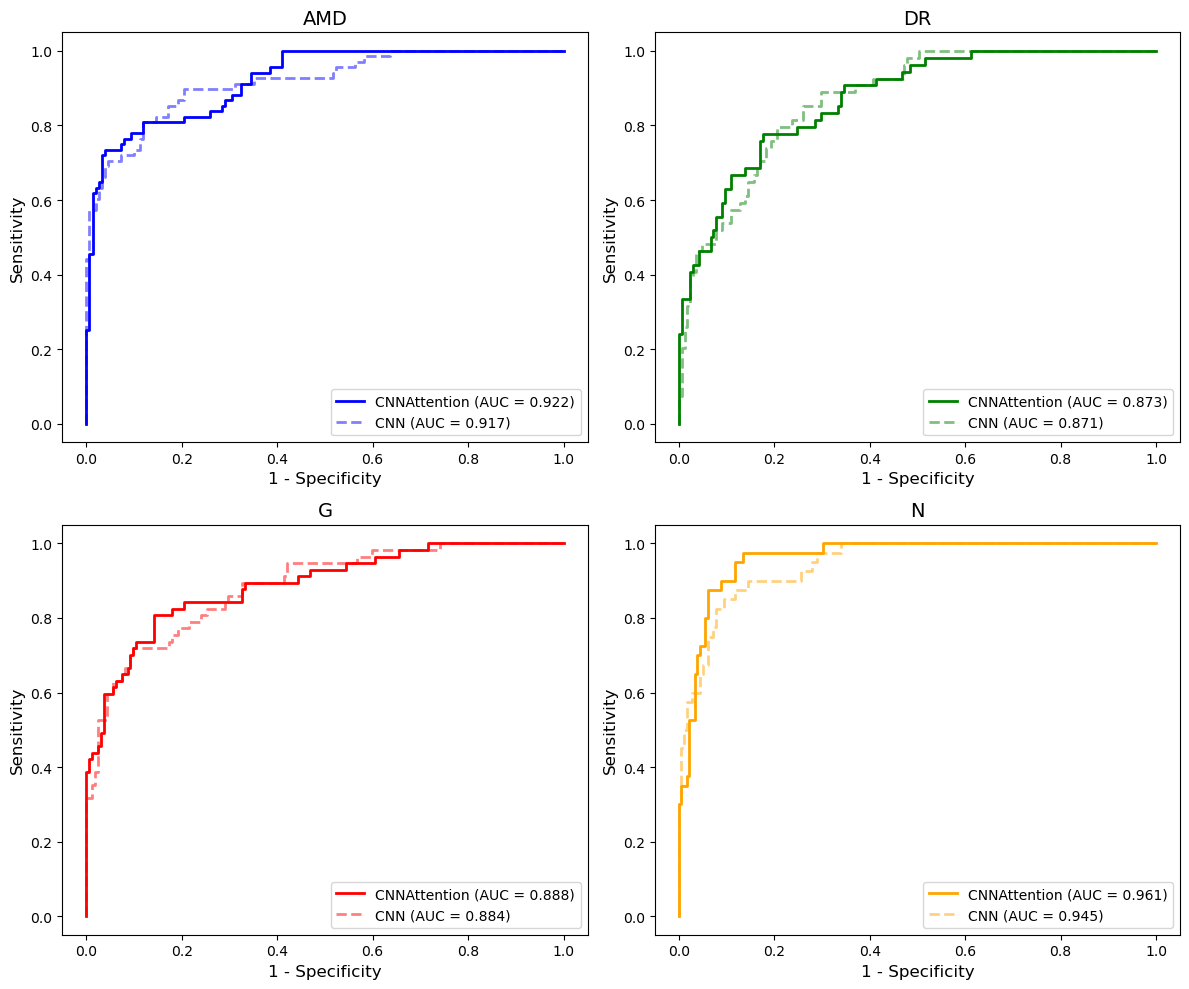

In [54]:
# Classes and models
classes = ['AMD', 'DR', 'G', 'N']
best_model_name = best_model_roc
second_best_model_name = second_best_model_roc

# true labels and predicted probabilities
best_results = model_results[best_model_name]
second_best_results = model_results[second_best_model_name]

# Define colors for each class
colors = ['blue', 'green', 'red', 'orange']

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot ROC curves for each class
for i, class_name in enumerate(classes):
    # Compute ROC curve and AUC for the best model
    fpr_best, tpr_best, _ = roc_curve(best_results['labels'] == i, best_results['probs'][:, i])
    auc_best = auc(fpr_best, tpr_best)
    
    # Compute ROC curve and AUC for the second-best model
    fpr_second, tpr_second, _ = roc_curve(second_best_results['labels'] == i, second_best_results['probs'][:, i])
    auc_second = auc(fpr_second, tpr_second)

    # Plot in the corresponding subplot
    ax = axes[i]
    
    # Best model curve
    ax.plot(fpr_best, tpr_best, color=colors[i], label=f"{clean_model_name(best_model_name)} (AUC = {auc_best:.3f})", linewidth=2)
    
    # Second-best model curve (greyed out with dashed line)
    ax.plot(fpr_second, tpr_second, color=colors[i], linestyle='--', alpha=0.5, label=f"{clean_model_name(second_best_model_name)} (AUC = {auc_second:.3f})", linewidth=2)

    ax.set_title(f"{class_name}", fontsize=14)
    ax.set_xlabel("1 - Specificity", fontsize=12)
    ax.set_ylabel("Sensitivity", fontsize=12)
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [55]:
classes = ['AMD', 'DR', 'G', 'N']
best_model_name = best_model_roc
second_best_model_name = second_best_model_roc

# true labels and predicted probabilities for the best and second-best models
best_results = model_results[best_model_name]
second_best_results = model_results[second_best_model_name]

# Binarize the labels (one-vs-rest)
n_classes = best_results['probs'].shape[1]
labels_bin = label_binarize(best_results['labels'], classes=np.arange(n_classes))

# store thresholds for both models
best_thresholds = {}
second_best_thresholds = {}

for i in range(n_classes):
    # for the best model
    fpr_best, tpr_best, thresholds_best = roc_curve(labels_bin[:, i], best_results['probs'][:, i])

    # compute Youden's J statistic
    youden_j_best = tpr_best - fpr_best
    best_threshold_idx_best = np.argmax(youden_j_best)
    best_threshold = thresholds_best[best_threshold_idx_best]

    best_thresholds[f"Class {i}"] = best_threshold

    print(f"Best threshold for {classes[i]} (Best Model) based on Youden's index: {best_threshold}")

    # for the second-best model
    fpr_second, tpr_second, thresholds_second = roc_curve(labels_bin[:, i], second_best_results['probs'][:, i])
    youden_j_second = tpr_second - fpr_second
    best_threshold_idx_second = np.argmax(youden_j_second)
    second_best_threshold = thresholds_second[best_threshold_idx_second]
    second_best_thresholds[f"Class {i}"] = second_best_threshold

    print(f"Best threshold for {classes[i]} (Second Best Model) based on Youden's index: {second_best_threshold}")

print("\nBest thresholds for the best model:", best_thresholds)
print("Best thresholds for the second-best model:", second_best_thresholds)

Best threshold for AMD (Best Model) based on Youden's index: 0.5905893445014954
Best threshold for AMD (Second Best Model) based on Youden's index: 0.25587618350982666
Best threshold for DR (Best Model) based on Youden's index: 0.31960391998291016
Best threshold for DR (Second Best Model) based on Youden's index: 0.05219477415084839
Best threshold for G (Best Model) based on Youden's index: 0.1726711541414261
Best threshold for G (Second Best Model) based on Youden's index: 0.1966811865568161
Best threshold for N (Best Model) based on Youden's index: 0.15847396850585938
Best threshold for N (Second Best Model) based on Youden's index: 0.3514639437198639

Best thresholds for the best model: {'Class 0': 0.59058934, 'Class 1': 0.31960392, 'Class 2': 0.17267115, 'Class 3': 0.15847397}
Best thresholds for the second-best model: {'Class 0': 0.25587618, 'Class 1': 0.052194774, 'Class 2': 0.19668119, 'Class 3': 0.35146394}


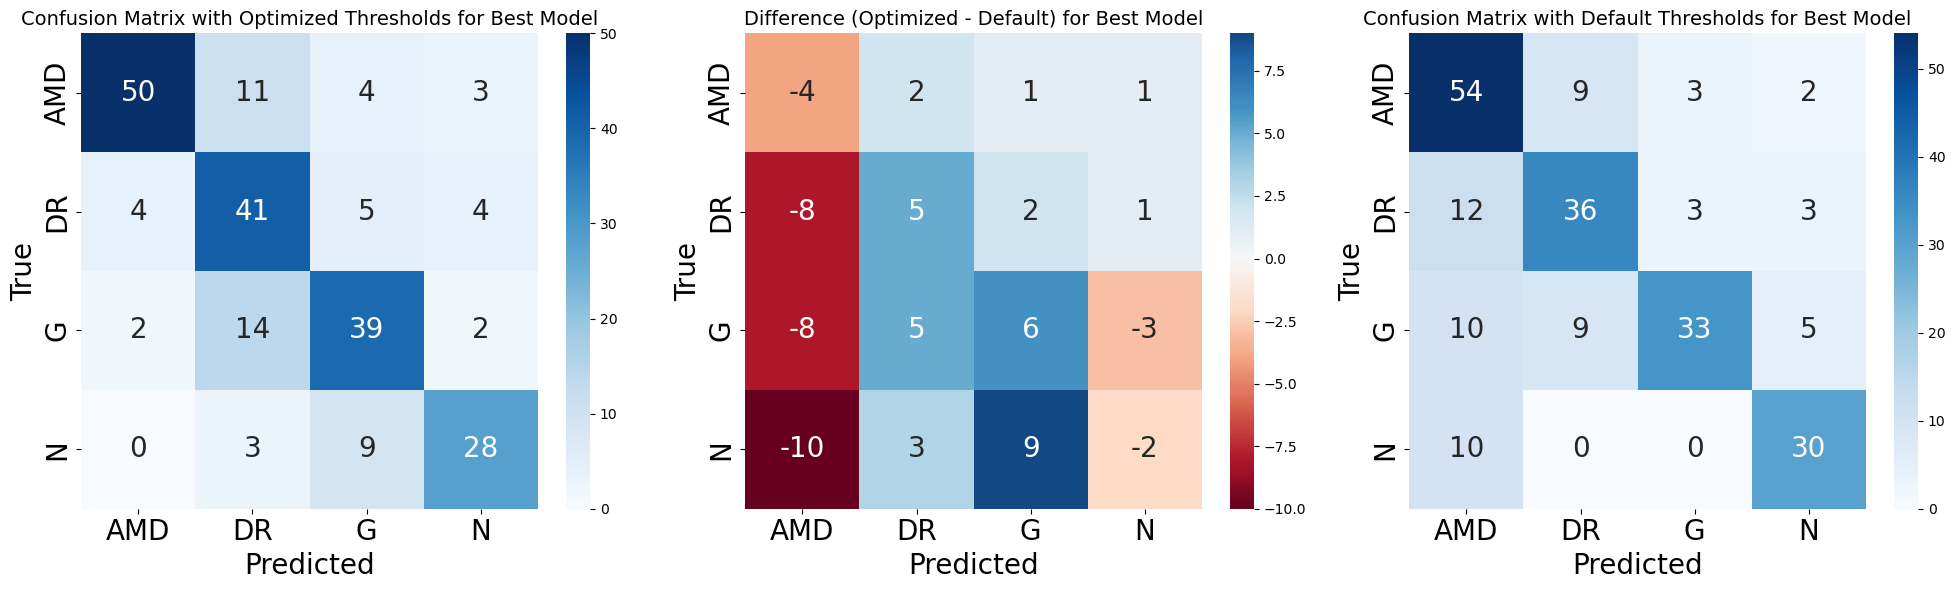

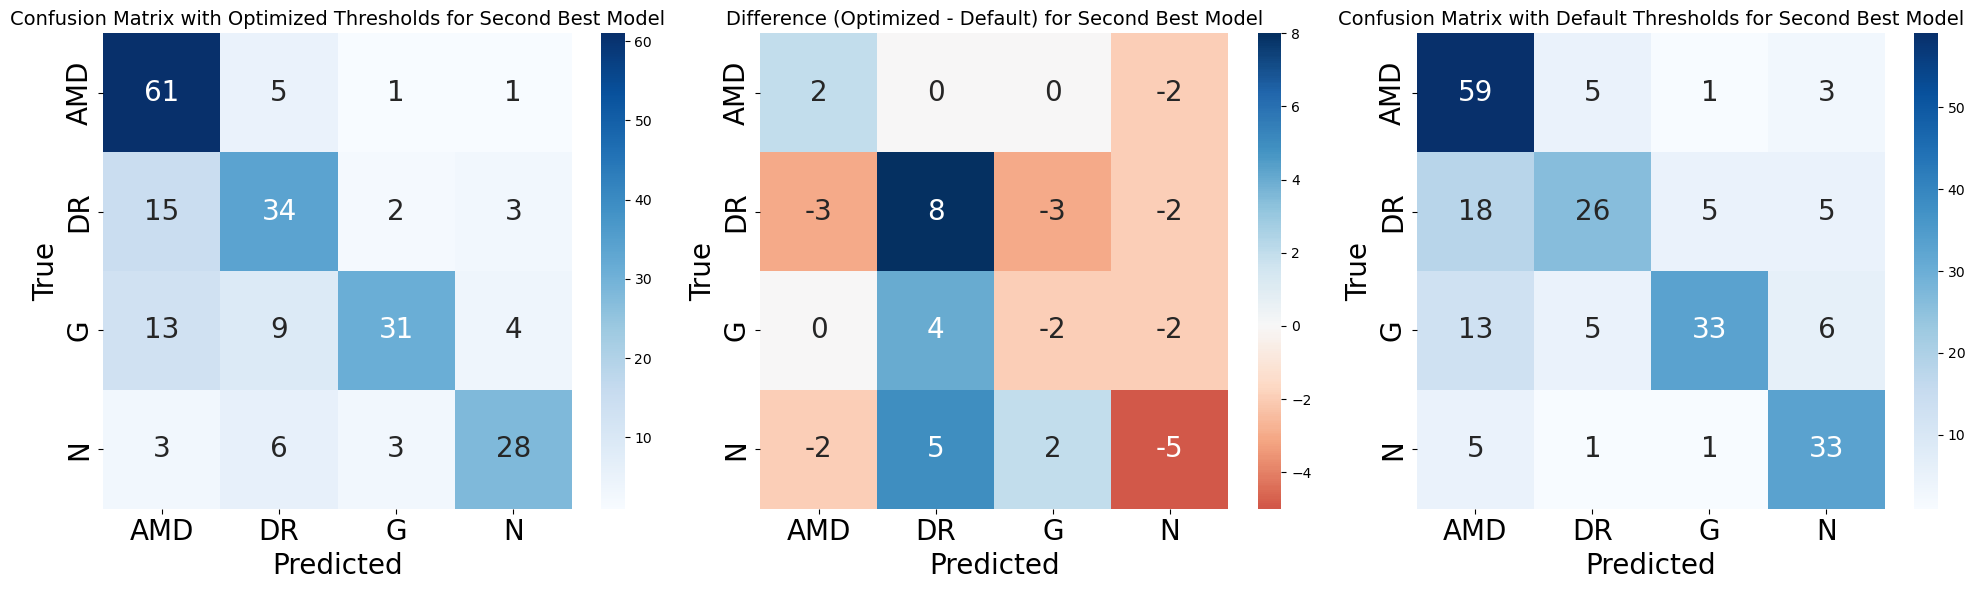

In [70]:
classes = ['AMD', 'DR', 'G', 'N']

# Function to calculate sensitivity and specificity
def calculate_sensitivity_specificity(cm, n_classes):
    sensitivity = {}
    specificity = {}
    for i in range(n_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (FP + FN + TP)
        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0
    return sensitivity, specificity

# Function to plot confusion matrix and difference matrix
def plot_confusion_matrices(model_name, labels, probs, optimized_thresholds, default_thresholds, n_classes, classes):
    # Apply optimized thresholds
    preds_optimized = []
    for prob in probs:
        class_preds = []
        for i in range(n_classes):
            if prob[i] >= optimized_thresholds[f"Class {i}"]:
                class_preds.append(1)
            else:
                class_preds.append(0)
        preds_optimized.append(np.argmax(class_preds))
    
    # Apply default thresholds (0.5)
    preds_default = []
    for prob in probs:
        class_preds = []
        for i in range(n_classes):
            if prob[i] >= default_thresholds[f"Class {i}"]:
                class_preds.append(1)
            else:
                class_preds.append(0)
        preds_default.append(np.argmax(class_preds))
    
    # Generate confusion matrices
    cm_optimized = confusion_matrix(labels, preds_optimized)
    cm_default = confusion_matrix(labels, preds_default)
    
    # Calculate the difference matrix
    cm_difference = cm_optimized - cm_default

    # Create a figure with three subplots: optimized, difference, and default confusion matrix
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot optimized confusion matrix
    sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axes[0], annot_kws={"size": 20})
    axes[0].set_title(f"Confusion Matrix with Optimized Thresholds for {model_name}", fontsize=14)
    axes[0].set_xlabel("Predicted", fontsize=20)
    axes[0].set_ylabel("True", fontsize=20)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=20)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=20)

    # Plot difference confusion matrix
    sns.heatmap(cm_difference, annot=True, fmt='d', cmap='RdBu', center=0, xticklabels=classes, yticklabels=classes, ax=axes[1], annot_kws={"size": 20})
    axes[1].set_title(f"Difference (Optimized - Default) for {model_name}", fontsize=14)
    axes[1].set_xlabel("Predicted", fontsize=20)
    axes[1].set_ylabel("True", fontsize=20)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=20)
    axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=20)
    
    # Plot default confusion matrix
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axes[2], annot_kws={"size": 20})
    axes[2].set_title(f"Confusion Matrix with Default Thresholds for {model_name}", fontsize=14)
    axes[2].set_xlabel("Predicted", fontsize=20)
    axes[2].set_ylabel("True", fontsize=20)
    axes[2].set_xticklabels(axes[2].get_xticklabels(), fontsize=20)
    axes[2].set_yticklabels(axes[2].get_yticklabels(), fontsize=20)

    plt.tight_layout()
    plt.show()

# Parameters for both models
models = {'Best Model': best_model_roc, 'Second Best Model': second_best_model_roc}
optimized_thresholds_all = {'Best Model': best_thresholds, 'Second Best Model': second_best_thresholds}
default_thresholds = {'Class 0': 0.5, 'Class 1': 0.5, 'Class 2': 0.5, 'Class 3': 0.5}

# Generate confusion matrices for both models
for model_name, model in models.items():
    labels = model_results[model]['labels']
    probs = model_results[model]['probs']
    optimized_thresholds = optimized_thresholds_all[model_name]
    
    plot_confusion_matrices(model_name, labels, probs, optimized_thresholds, default_thresholds, n_classes, classes)

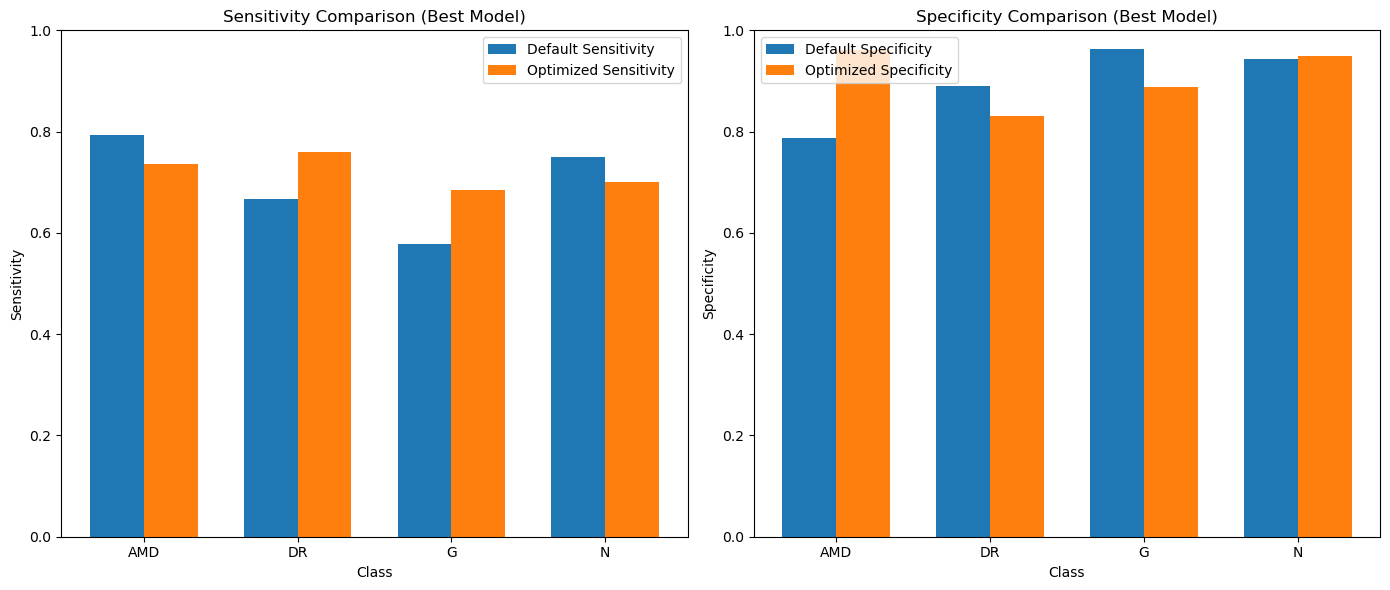

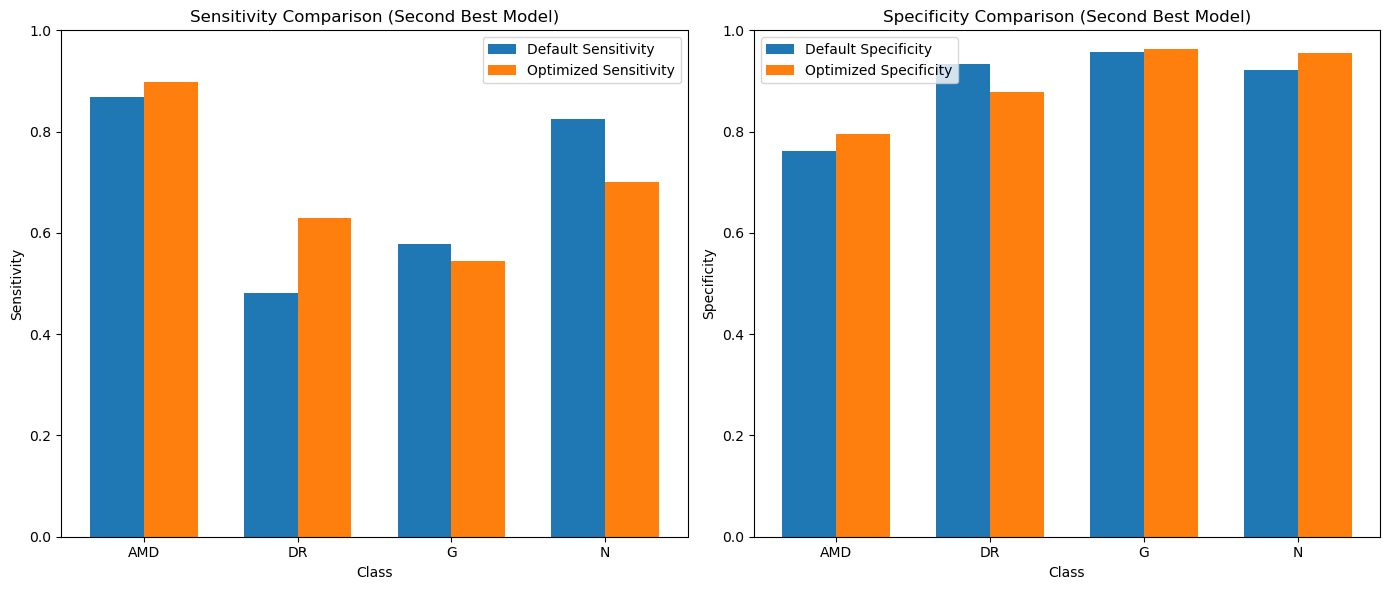

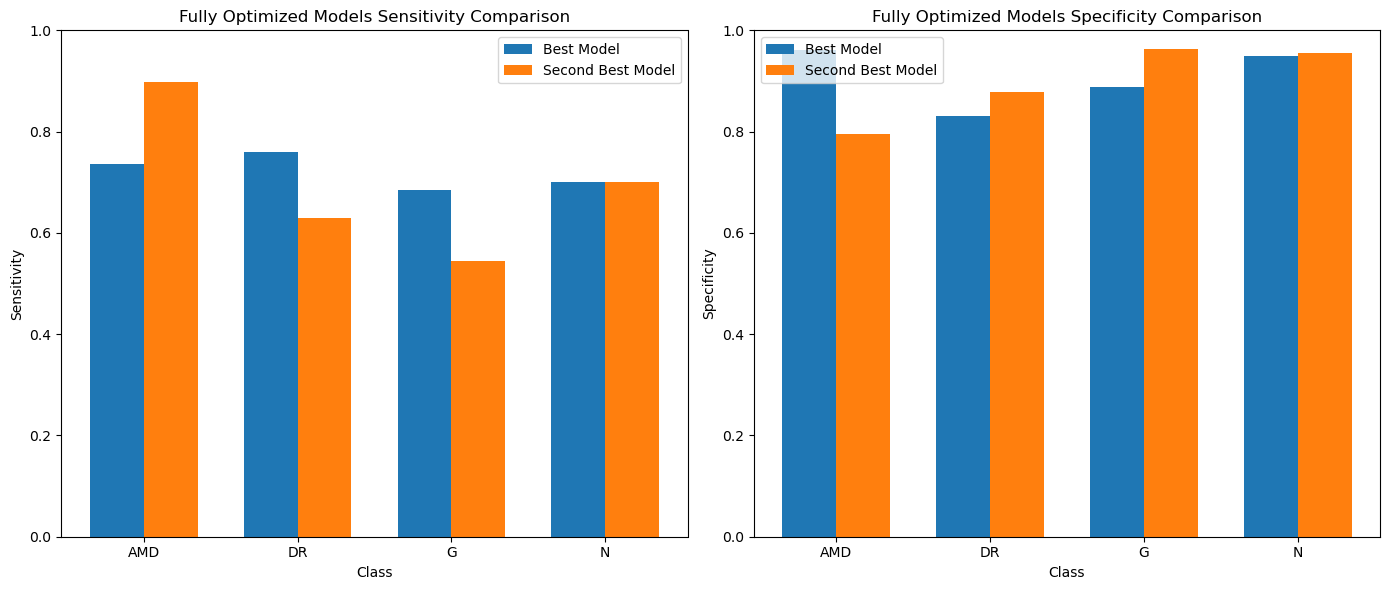

In [64]:
# Sensitivity and Specificity with default and optimized thresholds for both models
sensitivity_default = {}
specificity_default = {}
sensitivity_optimized = {}
specificity_optimized = {}
second_sensitivity_default = {}
second_specificity_default = {}
second_sensitivity_optimized = {}
second_specificity_optimized = {}

# function to generate default and optimized sensitivities and specificities
def evaluate_model(labels, probs, best_thresholds, model_name):
    sensitivity_default = {}
    specificity_default = {}
    sensitivity_optimized = {}
    specificity_optimized = {}

    # Apply default thresholds (0.5)
    preds_default = []
    thresholds_default = {'Class 0': 0.5, 'Class 1': 0.5, 'Class 2': 0.5, 'Class 3': 0.5}

    for prob in probs:
        class_preds = []
        for i in range(len(thresholds_default)):
            if prob[i] >= thresholds_default[f"Class {i}"]:
                class_preds.append(1)
            else:
                class_preds.append(0)
        preds_default.append(np.argmax(class_preds))

    # Generate confusion matrix with default thresholds
    cm_default = confusion_matrix(labels, preds_default)
    sensitivity_default, specificity_default = calculate_sensitivity_specificity(cm_default, n_classes)

    # Apply optimized thresholds
    preds_optimized = []
    for prob in probs:
        class_preds = []
        for i in range(len(best_thresholds)):
            if prob[i] >= best_thresholds[f"Class {i}"]:
                class_preds.append(1)
            else:
                class_preds.append(0)
        preds_optimized.append(np.argmax(class_preds))

    # Generate confusion matrix with optimized thresholds
    cm_optimized = confusion_matrix(labels, preds_optimized)
    sensitivity_optimized, specificity_optimized = calculate_sensitivity_specificity(cm_optimized, n_classes)

    return sensitivity_default, specificity_default, sensitivity_optimized, specificity_optimized

# Evaluate best model
model_name = best_model_roc
labels = model_results[model_name]['labels']
probs = model_results[model_name]['probs']
sensitivity_default, specificity_default, sensitivity_optimized, specificity_optimized = evaluate_model(labels, probs, best_thresholds, model_name)

# Evaluate second-best model
model_name = second_best_model_roc
labels = model_results[model_name]['labels']
probs = model_results[model_name]['probs']
second_sensitivity_default, second_specificity_default, second_sensitivity_optimized, second_specificity_optimized = evaluate_model(labels, probs, second_best_thresholds, model_name)

# separate Bar Plots for Sensitivity and Specificity

classes = ['AMD', 'DR', 'G', 'N']
x = np.arange(len(classes))
bar_width = 0.35

# Best Model Sensitivity and Specificity Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Sensitivity bar plot
ax1.bar(x - bar_width/2, [sensitivity_default[i] for i in range(n_classes)], bar_width, label='Default Sensitivity')
ax1.bar(x + bar_width/2, [sensitivity_optimized[i] for i in range(n_classes)], bar_width, label='Optimized Sensitivity')
ax1.set_ylim(0, 1)
ax1.set_xlabel('Class')
ax1.set_ylabel('Sensitivity')
ax1.set_title(f'Sensitivity Comparison (Best Model)')
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.legend()

# Specificity bar plot
ax2.bar(x - bar_width/2, [specificity_default[i] for i in range(n_classes)], bar_width, label='Default Specificity')
ax2.bar(x + bar_width/2, [specificity_optimized[i] for i in range(n_classes)], bar_width, label='Optimized Specificity')
ax2.set_ylim(0, 1)
ax2.set_xlabel('Class')
ax2.set_ylabel('Specificity')
ax2.set_title(f'Specificity Comparison (Best Model)')
ax2.set_xticks(x)
ax2.set_xticklabels(classes)
ax2.legend()

plt.tight_layout()
plt.show()

# second-Best Model Sensitivity and Specificity Comparison
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))

# Sensitivity bar plot
ax3.bar(x - bar_width/2, [second_sensitivity_default[i] for i in range(n_classes)], bar_width, label='Default Sensitivity')
ax3.bar(x + bar_width/2, [second_sensitivity_optimized[i] for i in range(n_classes)], bar_width, label='Optimized Sensitivity')
ax3.set_ylim(0, 1)
ax3.set_xlabel('Class')
ax3.set_ylabel('Sensitivity')
ax3.set_title(f'Sensitivity Comparison (Second Best Model)')
ax3.set_xticks(x)
ax3.set_xticklabels(classes)
ax3.legend()

# Specificity bar plot
ax4.bar(x - bar_width/2, [second_specificity_default[i] for i in range(n_classes)], bar_width, label='Default Specificity')
ax4.bar(x + bar_width/2, [second_specificity_optimized[i] for i in range(n_classes)], bar_width, label='Optimized Specificity')
ax4.set_ylim(0, 1)
ax4.set_xlabel('Class')
ax4.set_ylabel('Specificity')
ax4.set_title(f'Specificity Comparison (Second Best Model)')
ax4.set_xticks(x)
ax4.set_xticklabels(classes)
ax4.legend()

plt.tight_layout()
plt.show()

# fully Optimized Models Comparison
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(14, 6))

# Comparing optimized sensitivities of best and second-best models
ax5.bar(x - bar_width/2, [sensitivity_optimized[i] for i in range(n_classes)], bar_width, label='Best Model')
ax5.bar(x + bar_width/2, [second_sensitivity_optimized[i] for i in range(n_classes)], bar_width, label='Second Best Model')
ax5.set_ylim(0, 1)
ax5.set_xlabel('Class')
ax5.set_ylabel('Sensitivity')
ax5.set_title(f'Fully Optimized Models Sensitivity Comparison')
ax5.set_xticks(x)
ax5.set_xticklabels(classes)
ax5.legend()

# Comparing optimized specificities of best and second-best models
ax6.bar(x - bar_width/2, [specificity_optimized[i] for i in range(n_classes)], bar_width, label='Best Model')
ax6.bar(x + bar_width/2, [second_specificity_optimized[i] for i in range(n_classes)], bar_width, label='Second Best Model')
ax6.set_ylim(0, 1)
ax6.set_xlabel('Class')
ax6.set_ylabel('Specificity')
ax6.set_title(f'Fully Optimized Models Specificity Comparison')
ax6.set_xticks(x)
ax6.set_xticklabels(classes)
ax6.legend()

plt.tight_layout()
plt.show()